In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
inspector = inspect(engine)
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

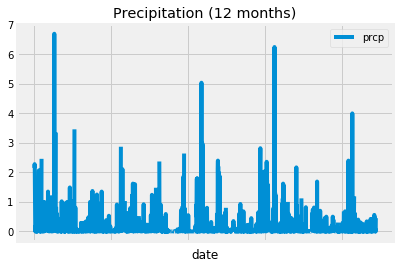

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
# Calculate the date 1 year ago from the last data point in the database
first_date = dt.datetime.strptime(last_date,'%Y-%m-%d') - dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
year = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= first_date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(year).set_index('date')
# Sort the dataframe by date
df = df.sort_values(by='date',ascending=True)
# Use Pandas Plotting with Matplotlib to plot the data
df.plot(title="Precipitation (12 months)")
plt.legend()
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Measurement.station).distinct().count()
stations

9

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = (session.query(Measurement.station,func.count(Measurement.station))
                   .group_by(Measurement.station).order_by(func.count(Measurement.station)
                        .desc()).all())
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_temp = (session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), 
                        func.max(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all())
most_active_temp

[(54.0, 71.66378066378067, 85.0)]

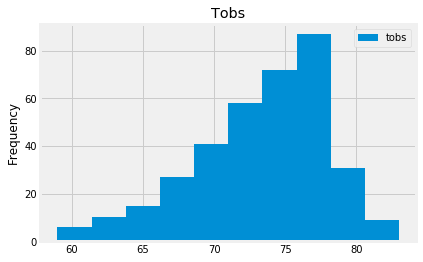

In [22]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
end = (session.query(Measurement.date).filter(Measurement.station == 'USC00519281').
       order_by(Measurement.date.desc()).first())[0]
begin = dt.datetime.strptime(end,'%Y-%m-%d') - dt.timedelta(days=365)
station_12m = (session.query(Measurement.tobs).filter(Measurement.date >= begin)
                .filter(Measurement.date <= end).filter(Measurement.station == 'USC00519281').all())
histogram = pd.DataFrame(station_12m, columns = ['tobs'])
label = ['tobs']
plt.hist(histogram['tobs'])
plt.ylabel('Frequency')
plt.title('Tobs')
plt.legend(label)
plt.show()

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
my_trip = calc_temps('2017-08-09', '2017-08-23')[0]
my_trip_l = ['min','avg','max']
ran = my_trip[2] - my_trip[0]

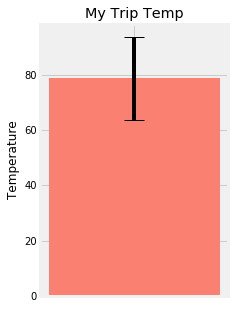

In [25]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(3,5))
plt.bar(my_trip_l[1], my_trip[1], yerr=ran, tick_label='', color='salmon',ecolor='black', capsize=10)
plt.ylabel("Temperature")
plt.title("My Trip Temp")
plt.show()

In [ ]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
